In [1]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import DenseNet201, InceptionResNetV2, ResNet50
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Flatten, Concatenate
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, concatenate, Dense
from tensorflow.keras.models import Model


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
def lr_scheduler(epoch):
    initial_learning_rate = 0.001
    drop = 0.5
    epochs_drop = 5
    lr = initial_learning_rate * tf.math.pow(drop, tf.math.floor((1 + epoch) / epochs_drop))
    return lr

In [3]:
train_dir = '/kaggle/input/labeled-chest-xray-images/chest_xray/test'
validation_dir ='/kaggle/input/validation1/val'

In [4]:
def hybrid_cnn_model(input_shape=(150, 150, 3)):
    inputs = Input(shape=input_shape)
    
    # Base models from different architectures
    densenet_model = DenseNet201(input_shape=input_shape, include_top=False, weights='imagenet')(inputs)
    inceptionresnet_model = InceptionResNetV2(input_shape=input_shape, include_top=False, weights='imagenet')(inputs)
    resnet_model = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')(inputs)

    # Add a Conv2D layer and GlobalAveragePooling2D to each base model to reduce spatial dimensions
    densenet_model = Conv2D(128, (3, 3), activation='relu')(densenet_model)
    densenet_model = GlobalAveragePooling2D()(densenet_model)

    inceptionresnet_model = Conv2D(128, (3, 3), activation='relu')(inceptionresnet_model)
    inceptionresnet_model = GlobalAveragePooling2D()(inceptionresnet_model)

    resnet_model = Conv2D(128, (3, 3), activation='relu')(resnet_model)
    resnet_model = GlobalAveragePooling2D()(resnet_model)

    # Concatenate the output of the three base models
    x = concatenate([densenet_model, inceptionresnet_model, resnet_model])
    
    # Dense layers
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    
    # Output layer
    output_layer = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=output_layer)
    return model

model = hybrid_cnn_model()

94765736/94765736 [==============================] - 3s 0us/step


In [5]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Define the learning rate scheduler callback
lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

optimizer = RMSprop(learning_rate=0.001)  # Set the initial learning rate here
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy']) 

In [6]:

# Data augmentation for training data
train_datagen = ImageDataGenerator(rescale=1.0/255.0,       # Normalize pixel values to [0,1]
                                   shear_range=0.2,        # Shear transformation
                                   zoom_range=0.2,         # Zoom transformation
                                   horizontal_flip=True)   # Horizontal flip

# No data augmentation for validation data, only rescale
validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Batch size for training and validation
batch_size = 16

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=batch_size,
                                                    class_mode='binary')

# Flow validation images in batches of 32 using validation_datagen
validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              target_size=(150, 150),
                                                              batch_size=batch_size,
                                                              class_mode='binary')


Found 624 images belonging to 2 classes.
Found 403 images belonging to 2 classes.


In [9]:
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    callbacks=[lr_scheduler_callback]) 

Epoch 1/100
39/39 [==============================] - 18s 467ms/step - loss: 0.1953 - accuracy: 0.9279 - val_loss: 2.2249 - val_accuracy: 0.8412 - lr: 0.0010
Epoch 2/100
39/39 [==============================] - 18s 464ms/step - loss: 0.1812 - accuracy: 0.9519 - val_loss: 0.7781 - val_accuracy: 0.9032 - lr: 0.0010
Epoch 3/100
39/39 [==============================] - 18s 455ms/step - loss: 0.1360 - accuracy: 0.9599 - val_loss: 1.0205 - val_accuracy: 0.7692 - lr: 0.0010
Epoch 4/100
39/39 [==============================] - 18s 460ms/step - loss: 0.1175 - accuracy: 0.9599 - val_loss: 0.0885 - val_accuracy: 0.9727 - lr: 0.0010
Epoch 5/100
39/39 [==============================] - 18s 465ms/step - loss: 0.0642 - accuracy: 0.9840 - val_loss: 0.2974 - val_accuracy: 0.8983 - lr: 5.0000e-04
Epoch 6/100
39/39 [==============================] - 18s 466ms/step - loss: 0.0510 - accuracy: 0.9856 - val_loss: 0.0742 - val_accuracy: 0.9777 - lr: 5.0000e-04
Epoch 7/100
39/39 [==============================]

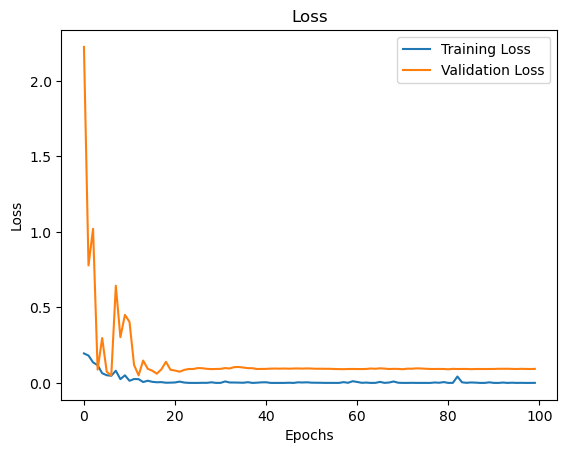

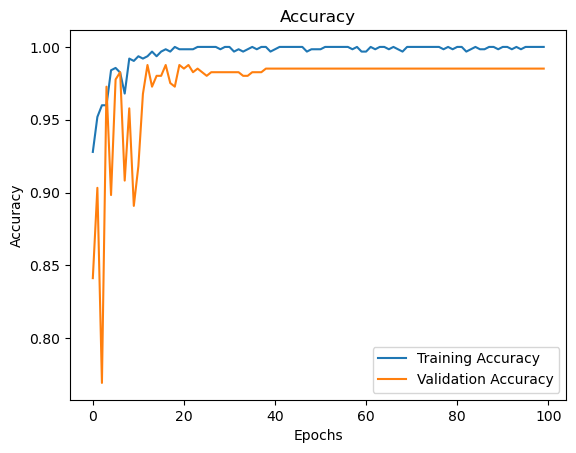

In [10]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [11]:
# Access the final validation accuracy and other metrics
final_val_accuracy = history.history['val_accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")


Final Validation Accuracy: 0.9851
Final Validation Loss: 0.0931


In [12]:
# Print all available metrics
for metric in history.history.keys():
    print(f"{metric}: {history.history[metric][-1]}")


loss: 0.00045099883573129773
accuracy: 1.0
val_loss: 0.09307026118040085
val_accuracy: 0.985111653804779
lr: 9.536743617033494e-10
